In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix, make_scorer
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb

In [3]:
nba_2017 = pd.read_csv('/content/NBA Players Stats 201718.csv')
nba_2017['Player'] = nba_2017['Player'].str.split('\\').str[0]
duplicated_players = nba_2017['Player'].duplicated(keep=False)

mask = duplicated_players & (nba_2017['Tm'] == 'TOT')


filtered_df = nba_2017[mask]


single_team_df = nba_2017[~duplicated_players]


nba_2017_2018 = pd.concat([filtered_df, single_team_df])
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)
nba_2017_2018 = nba_2017_2018.drop(columns=['Rk','Tm', 'Pos'], axis=1)
nba_2017_2018.fillna(0, inplace=True)
nba_2017_2018 = nba_2017_2018[nba_2017_2018['G'] >= 20]
nba_2017_2018 = nba_2017_2018.reset_index(drop=True)

percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2017_2018[col] = nba_2017_2018[col] * 100

all_star_list = ['Kemba Walker', 'Kyrie Irving', 'Kawhi Leonard', 'Giannis Antetokounmpo', 
                'Joel Embiid', 'Kyle Lowry', 'Victor Oladipo', 'Khris Middleton', 'Bradley Beal',
                'Ben Simmons', 'Blake Griffin', 'Nikola Vučević', "D'Angelo Russell",
                'Stephen Curry', 'James Harden', 'Kevin Durant', 'Paul George', 'LeBron James',
                'Russell Westbrook', 'Damian Lillard', 'Klay Thompson', 'Anthony Davis', 
                'LaMarcus Aldridge', 'DeMarcus Cousins', 'Nikola Jokić', 'Karl-Anthony Towns']
nba_2017_2018['AS_NY'] = nba_2017_2018['Player'].apply(lambda x: 1 if x in all_star_list else 0)

In [4]:
nba_2017_2018.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS_NY
0,Luke Babbitt,28,50,14,14.3,1.8,4.3,42.3,1.2,3.1,...,0.1,1.8,1.9,0.6,0.2,0.1,0.4,1.1,5.2,0
1,Marco Belinelli,31,80,2,24.3,4.2,9.6,44.1,1.9,4.9,...,0.3,1.6,1.9,1.9,0.8,0.2,1.2,1.1,12.1,0
2,Eric Bledsoe,28,74,74,31.4,6.3,13.4,47.3,1.7,4.9,...,0.7,3.1,3.8,5.0,2.0,0.6,2.9,2.5,17.7,0
3,Trevor Booker,30,68,7,17.0,2.6,5.0,51.6,0.1,0.5,...,1.7,3.0,4.7,1.2,0.4,0.3,0.9,1.8,6.3,0
4,Avery Bradley,27,46,46,31.2,5.6,13.6,41.4,1.6,4.4,...,0.5,2.0,2.5,2.0,1.1,0.2,2.2,2.0,14.3,0


In [5]:
nba_2018 = pd.read_csv('/content/NBA Players Stats 201819.csv')
nba_2018['Player'] = nba_2018['Player'].str.split('\\').str[0]
duplicated_players = nba_2018['Player'].duplicated(keep=False)

mask = duplicated_players & (nba_2018['Tm'] == 'TOT')


filtered_df = nba_2018[mask]


single_team_df = nba_2018[~duplicated_players]


nba_2018_2019 = pd.concat([filtered_df, single_team_df])
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)
nba_2018_2019 = nba_2018_2019.drop(columns=['Rk','Tm', 'Pos'], axis=1)
nba_2018_2019.fillna(0, inplace=True)
nba_2018_2019 = nba_2018_2019[nba_2018_2019['G'] >= 20]
nba_2018_2019 = nba_2018_2019.reset_index(drop=True)

percentage_columns = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']
for col in percentage_columns:
    nba_2018_2019[col] = nba_2018_2019[col] * 100

all_star_list = ['Kemba Walker', 'Trae Young', 'Giannis Antetokounmpo', 'Pascal Siakam', 'Joel Embiid',
                'Kyle Lowry', 'Ben Simmons', 'Jimmy Butler', 'Khris Middleton', 'Bam Adebayo', 
                'Jayson Tatum', 'Domantas Sabonis', 'James Harden', 'Luka Dončić', 'LeBron James',
                'Kawhi Leonard', 'Anthony Davis', 'Chris Paul', 'Russell Westbrook', 'Damian Lillard', 
                'Donovan Mitchell', 'Brandon Ingram', 'Nikola Jokić', 'Rudy Gobert', 'Devin Booker']
nba_2018_2019['AS_NY'] = nba_2018_2019['Player'].apply(lambda x: 1 if x in all_star_list else 0)

In [6]:
nba_2018_2019.head()

,Player,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS_NY
0,Ryan Anderson,30,25,8,12.9,0.8,2.8,30.4,0.4,1.6,...,0.7,1.4,2.2,0.8,0.2,0.0,0.6,1.0,2.5,0
1,Trevor Ariza,33,69,69,34.0,4.3,10.7,39.9,2.1,6.3,...,0.7,4.7,5.4,3.7,1.3,0.3,1.5,1.9,12.5,0
2,Harrison Barnes,26,77,77,32.9,5.6,13.3,42.0,2.3,5.7,...,0.7,3.9,4.7,1.5,0.6,0.2,1.3,1.6,16.4,0
3,Avery Bradley,28,63,63,30.2,3.9,9.7,40.8,1.4,3.9,...,0.7,2.1,2.8,2.4,0.7,0.3,1.4,2.7,9.9,0
4,Corey Brewer,32,31,3,15.9,1.7,4.0,43.1,0.5,1.4,...,0.8,1.6,2.5,1.3,1.0,0.2,0.6,2.0,4.9,0


In [7]:
X_train = nba_2017_2018.drop(['Player', 'AS_NY'], axis=1) 
y_train = nba_2017_2018['AS_NY']  

X_test = nba_2018_2019.drop(['Player', 'AS_NY'], axis=1)  
y_test = nba_2018_2019['AS_NY']  

In [19]:
#Finding optimal hyperparameters
n_samples = X_train.shape[0]
n_features = X_train.shape[1]

params = {'base_estimator': [DecisionTreeClassifier(random_state = 1)],
          'n_estimators': [250,300,350,400,450,500,550],
          'max_samples': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]}

cv = KFold(n_splits=5,shuffle=True,random_state=1)
bagging_classifier_grid = GridSearchCV(BaggingClassifier(random_state=1, n_jobs=-1), 
                                      param_grid =params, cv=cv, n_jobs=-1, verbose=1,
                                      scoring = ['precision', 'recall'], refit='recall')
bagging_classifier_grid.fit(X_train, y_train)

print('Train accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_train, y_train))
print('Test accuracy : %.3f'%bagging_classifier_grid.best_estimator_.score(X_test, y_test))
print('Best accuracy Through Grid Search : %.3f'%bagging_classifier_grid.best_score_)
print('Best Parameters : ',bagging_classifier_grid.best_params_)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train accuracy : 1.000
Test accuracy : 0.931
Best accuracy Through Grid Search : 0.843
Best Parameters :  {'base_estimator': DecisionTreeClassifier(random_state=1), 'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 350}


In [20]:
#Best model
model = bagging_classifier_grid.best_estimator_

In [30]:
X_train.shape

(414, 26)

In [32]:
#Feature importances
# Data structure to store sum of feature importance and number of times it showed up
total = [0] * 26
# Loop through every tree in bagging regressor
for i, temp_model in enumerate(model.estimators_): # model is bagging regressor
    feature = model.estimators_features_[i] # Get the predictors the specific tree uses
    for j, predictor in enumerate(feature): # loop the predictors
        total[predictor] += temp_model.feature_importances_[j] # Add the specific feature importance to the array
imps = np.array(total)/len(model.estimators_) #convert to numpy array for easy elementwise division

pd.Series(imps, index = X_train.columns).sort_values(ascending = False)

PTS     0.418428
FG      0.173986
eFG%    0.136586
TOV     0.058745
DRB     0.032923
TRB     0.022850
3P      0.022044
AST     0.017555
3PA     0.015956
FGA     0.012222
FT      0.011637
FT%     0.009601
2P%     0.008864
GS      0.007208
FTA     0.006705
Age     0.005447
ORB     0.005418
PF      0.005127
MP      0.004969
STL     0.004413
2PA     0.003553
FG%     0.003498
G       0.003455
BLK     0.003384
2P      0.002721
3P%     0.002705
dtype: float64

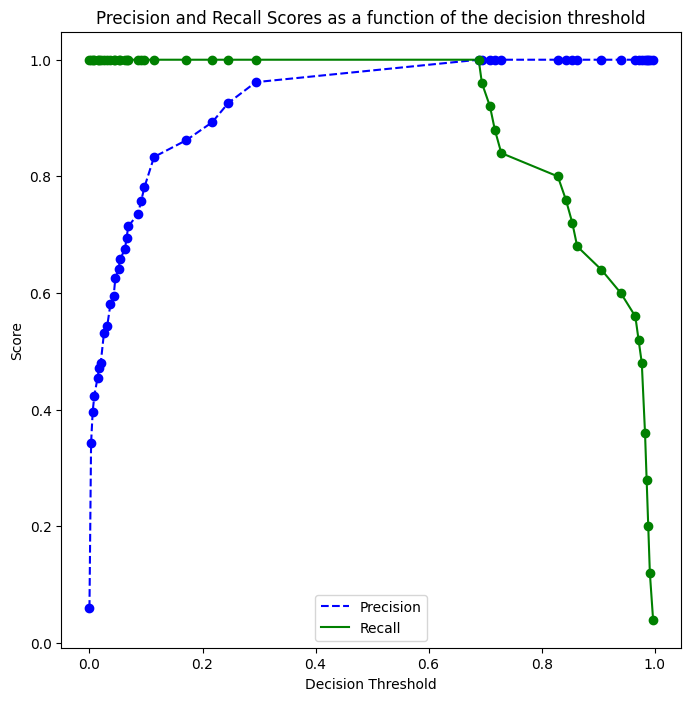

In [23]:
#Tuning threshold
ypred = model.predict_proba(X_train)[:,1]
p, r, thresholds = precision_recall_curve(y_train, ypred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [26]:
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_80 = all_thresholds[all_thresholds[:,2]>0.6,:]
recall_more_than_80[recall_more_than_80.shape[0]-1]

array([0.90571429, 1.        , 0.64      ])

Accuracy:  93.14420803782507
ROC-AUC:  0.8678391959798994
Precision:  0.42857142857142855
Recall:  0.48


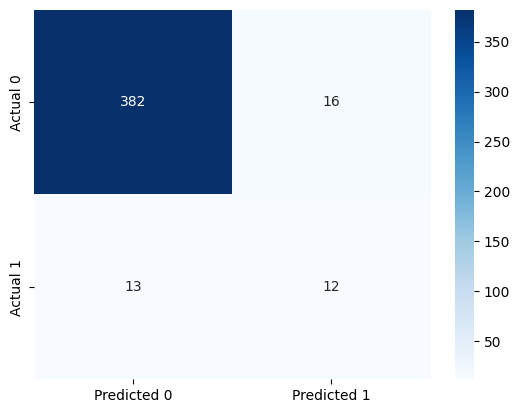

In [27]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.64

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [33]:
misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 0 and y_test.iloc[i] == 1]

print("Players predicted as 0 but actually belong to class 1:")
for player in misclassified_players:
    print(player)

Players predicted as 0 but actually belong to class 1:
Jimmy Butler
Bam Adebayo
Rudy Gobert
Brandon Ingram
Kyle Lowry
Khris Middleton
Donovan Mitchell
Chris Paul
Domantas Sabonis
Pascal Siakam
Jayson Tatum
Kemba Walker
Trae Young


In [34]:
misclassified_players = [nba_2018_2019.loc[i, 'Player'] for i in range(len(y_pred)) if y_pred[i] == 1 and y_test.iloc[i] == 0]

print("Players predicted as 1 but actually belong to class 0:")
for player in misclassified_players:
    print(player)

Players predicted as 1 but actually belong to class 0:
Tobias Harris
LaMarcus Aldridge
Bradley Beal
Stephen Curry
Kevin Durant
Paul George
Blake Griffin
Buddy Hield
Jrue Holiday
Kyrie Irving
Zach LaVine
CJ McCollum
Julius Randle
Klay Thompson
Karl-Anthony Towns
Nikola Vučević
